# Stochastic amplified variance gradient experiments

Minimize the function $$f_{\gamma}(x) = \frac{1}{2} (x-\gamma)^T H (x-\gamma) - \frac{1}{2} Tr(H)$$, where $\gamma \sim \mathcal{N}(0,I)$.
The gradient is given by $$\nabla f_{\gamma}(x) = H(x - \gamma).$$ The stochastic gradient descent iterates are given by $$x_{k+1} = x_k - \eta H(x_k - \gamma).$$


In [1]:
import jax.numpy as jnp
import jax.scipy.linalg as linalg
from jax import random
from noisy_gradient_descent import *
from gradient_descent import gradient_descent_update
from network import *
from stochastic_variance_amplified_gradient import *

jax.config.update('jax_platform_name', 'cpu')


In [14]:
def loss(x, gamma, H):
    return 0.5 * (x - gamma).T @ H @ (x - gamma) - 0.5 * jnp.trace(H)


In [18]:
@jit
# @partial(jax.vmap, in_axes=(0,None, None, None))
def expected_loss(time, initial_value, H, learning_rate):
    decay_term = 0.5 * initial_value.T @ H @ linalg.expm(
        -2.0 * time * H) @ initial_value
    # Eigenvalue in ascending order
    eigenvalues, _ = linalg.eigh(H)
    noise_term = 0.25 * learning_rate * jnp.sum(
        jnp.square(eigenvalues) * (1 - jnp.exp(-2.0 * time * eigenvalues)))
    return decay_term + noise_term


@jit
def expected_second_order_loss(time, initial_value, H, learning_rate):
    n, _ = H.shape
    decay_term = 0.5 * initial_value.T @ H @ linalg.expm(
        H @ (learning_rate * H - 2.0 * jnp.identity(n)) * time) @ initial_value
    eigenvalues, _ = linalg.eigh(H)
    noise_term = 0.5 * learning_rate * jnp.sum(
        jnp.square(eigenvalues) / (2 - learning_rate * eigenvalues) *
        (1 - jnp.exp(eigenvalues *
                     (learning_rate * eigenvalues - 2.0) * time)))
    return decay_term + noise_term


In [11]:
NUMBER_OF_VARIABLES = 3
INITIAL_VALUE_NOISE_SCALING = 5.0
FINAL_TIME = 2.0
LEARNING_RATE = 0.001
number_of_time_points = int(FINAL_TIME / LEARNING_RATE)

key = random.PRNGKey(5)
key, subkey = random.split(key)
random_normal_matrix = random.normal(
    subkey, (NUMBER_OF_VARIABLES, NUMBER_OF_VARIABLES))
# H = random_normal_matrix.T @ random_normal_matrix
H = jnp.identity(NUMBER_OF_VARIABLES)
key, subkey = random.split(key)
x_0 = INITIAL_VALUE_NOISE_SCALING * random.normal(key, (NUMBER_OF_VARIABLES, ))

In [34]:
time = jnp.linspace(0.0, FINAL_TIME, number_of_time_points)

expected_loss_value = jax.vmap(expected_loss,
                               in_axes=(0, None, None, None))(time, x_0, H,
                                                              LEARNING_RATE)

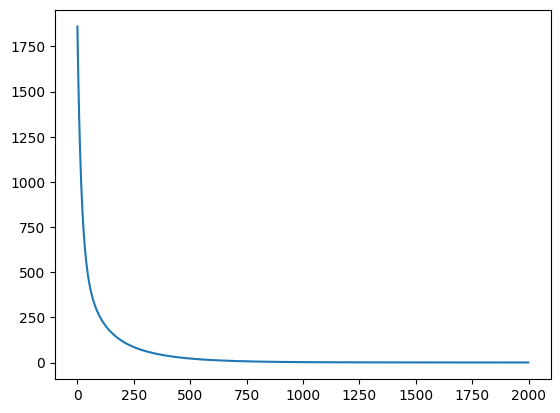

In [5]:
plt.plot(expected_loss_value)

In [12]:
@jit
@partial(jax.vmap, in_axes=(0, 0, None, None))
def stochastic_gradient_update(key, x, H, learning_rate):
    size, _ = H.shape
    normal_noise = random.normal(key, (size, ))
    value, gradient = jax.value_and_grad(loss)(x, normal_noise, H)
    updated_x = x - learning_rate * gradient
    return value, updated_x


# Average sampled loss with SGD


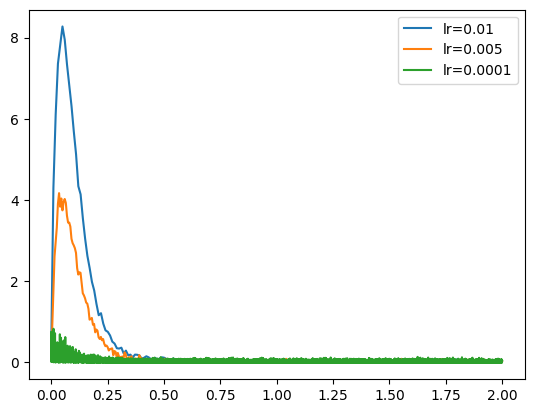

In [67]:
SAMPLES = 100000
LEARNING_RATES = [0.01, 0.005,0.0001]

for learning_rate in LEARNING_RATES:
    expected = []
    max_iterations = int(FINAL_TIME / learning_rate)
    time = jnp.linspace(0.0, FINAL_TIME, max_iterations)
    current_time = 0.0
    average = []
    x = jnp.repeat(x_0[:, jnp.newaxis], SAMPLES, axis=1).T
    current_time = 0
    for _ in range(max_iterations):
        key_array = random.split(key, SAMPLES + 1)
        key = key_array[-1]
        value, x = stochastic_gradient_update(key_array[:-1], x, H,
                                              learning_rate)
        average.append(
            jnp.average(value))
        expected.append(expected_loss(current_time, x_0, H, learning_rate))
        current_time += learning_rate
    plt.plot(time, jnp.abs(jnp.array(average) - jnp.array(expected)), label=f'lr={learning_rate}')
    plt.legend()
# plt.savefig('/home/jonathan/forest/images/large_error_between_expected_and_sampled.png')


In [58]:
average[2]
# expected_loss(FINAL_TIME, x_0, H, 0.005)


DeviceArray(365.50412, dtype=float32)

# Recreating weak order 1 plot


In [25]:
from tqdm.auto import tqdm

SAMPLES = 1000000
LEARNING_RATES = jnp.linspace(0.05, 0.0001, 10)
sampled_values = []
for learning_rate in LEARNING_RATES:
    max_iterations = int(FINAL_TIME / learning_rate)

    x = jnp.repeat(x_0[:, jnp.newaxis], SAMPLES, axis=1).T
    
    for _ in tqdm(range(max_iterations)):
        key_array = random.split(key, SAMPLES + 1)
        key = key_array[-1]
        value, x = stochastic_gradient_update(key_array[:-1], x, H,
                                              learning_rate)

    sampled_values.append(jnp.average(value))


100%|██████████| 320/320 [06:40<00:00,  1.25s/it]


In [26]:
first_order_error = []
second_order_error = []
for learning_rate, sampled_value in zip(LEARNING_RATES, sampled_values):
    expected_loss_value = expected_loss(FINAL_TIME, x_0, H, learning_rate)
    expected_second_order_loss_value = expected_second_order_loss(
        FINAL_TIME, x_0, H, learning_rate)
    first_order_error.append(jnp.abs(sampled_value - expected_loss_value))
    second_order_error.append(
        jnp.abs(sampled_value - expected_second_order_loss_value))


In [27]:
A = jnp.column_stack(
    (jnp.log(jnp.array(LEARNING_RATES)), jnp.ones((len(LEARNING_RATES),))))
log_first_order_error = jnp.log(jnp.array(first_order_error))
log_second_order_error = jnp.log(jnp.array(second_order_error))
first_order_slope, _, _, _ = jnp.linalg.lstsq(A, log_first_order_error)
second_order_slope, _, _, _ = jnp.linalg.lstsq(A, log_second_order_error)
print(first_order_slope)
print(second_order_slope)

[ 0.74412936 -5.1811166 ]
[ 1.1177914  -0.33661255]


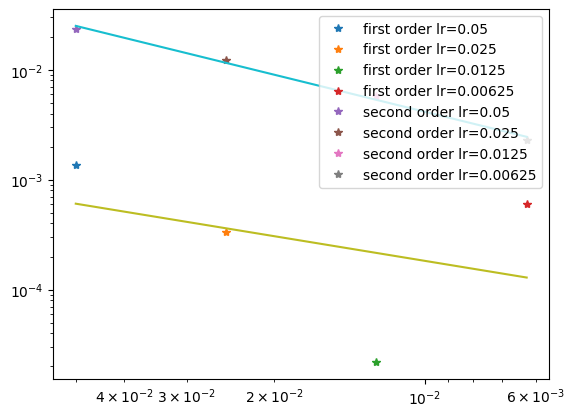

In [28]:
for learning_rate, error in zip(LEARNING_RATES, first_order_error):
    plt.plot(learning_rate,
             error,
             '*',
             label=f'first order lr={learning_rate}')
for learning_rate, error in zip(LEARNING_RATES, second_order_error):
    plt.plot(learning_rate,
             error,
             '*',
             label=f'second order lr={learning_rate}')
t = jnp.linspace(LEARNING_RATES[-1], LEARNING_RATES[0], 1000)
y = jnp.exp(first_order_slope[1]) * t**first_order_slope[0]
plt.plot(t, y, '-')
y = jnp.exp(second_order_slope[1]) * t**second_order_slope[0]
plt.plot(t, y, '-')
plt.gca().invert_xaxis()
plt.yscale('log')
plt.xscale('log')
plt.legend()
plt.savefig('/home/jonathan/forest/images/weak_order_2_SGD.png')

In [23]:
t


DeviceArray([0.00625   , 0.00629379, 0.00633759, 0.00638138, 0.00642518,
             0.00646897, 0.00651276, 0.00655656, 0.00660035, 0.00664414,
             0.00668794, 0.00673173, 0.00677553, 0.00681932, 0.00686311,
             0.00690691, 0.0069507 , 0.00699449, 0.00703829, 0.00708208,
             0.00712588, 0.00716967, 0.00721346, 0.00725726, 0.00730105,
             0.00734484, 0.00738864, 0.00743243, 0.00747623, 0.00752002,
             0.00756381, 0.00760761, 0.0076514 , 0.0076952 , 0.00773899,
             0.00778278, 0.00782658, 0.00787037, 0.00791416, 0.00795796,
             0.00800175, 0.00804555, 0.00808934, 0.00813313, 0.00817693,
             0.00822072, 0.00826451, 0.00830831, 0.0083521 , 0.0083959 ,
             0.00843969, 0.00848348, 0.00852728, 0.00857107, 0.00861487,
             0.00865866, 0.00870245, 0.00874625, 0.00879004, 0.00883383,
             0.00887763, 0.00892142, 0.00896521, 0.00900901, 0.0090528 ,
             0.0090966 , 0.00914039, 0.00918418, 0.

In [11]:
print(LEARNING_RATES)
print(errors)
A @ x


[0.1, 0.05, 0.025, 0.0125]
[DeviceArray(8.417173e+15, dtype=float32), DeviceArray(64.57793, dtype=float32), DeviceArray(6.527137, dtype=float32), DeviceArray(1.3048725, dtype=float32)]


DeviceArray([6.337636e+15, 3.168818e+15, 1.584409e+15, 7.922045e+14], dtype=float32)